In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from classes.AlexNet import AlexNet
from utils.functions import *

Definição das variaveis gerais

In [2]:
NUM_EPOCHS = 20
BATCH_SIZE = 64
MOMENTUM = 0.9
LR_DECAY = 0.0005
LR_INIT = 0.01
IMAGE_DIM = 227  # pixels
# DEVICE_IDS = [0, 1, 2, 3]  # GPUs to use
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
NUM_CLASSES = len(CIFAR10_CLASSES)

Seleciona em qual dispositivo será executado

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Tranformações para redimensionamento das imagens

In [4]:
# Defina as transformações para redimensionar e normalizar as imagens
transform = transforms.Compose([transforms.Resize((IMAGE_DIM, IMAGE_DIM)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Gera um conjunto de treinamento e de test

In [5]:
trainset, testset = load_cifar10(n_size=50, transform=transform)
# Defina o dataloader
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Cria a AlexNet

In [6]:

# Instancie a AlexNet
alexnet = AlexNet(num_classes=NUM_CLASSES).to(device)


Treinmanedo da rede

In [7]:
# Defina a função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=LR_INIT, momentum=MOMENTUM, weight_decay=LR_DECAY)

In [8]:
model_trained, metrics = make_train(alexnet, NUM_EPOCHS, optimizer,criterion,trainloader, testloader, device)

Epoch 1/20, Testing: 100%|██████████| 79/79 [00:06<00:00, 12.20it/s]


Epoch 1/20, Training Loss: 2.1178, Test Loss: 1.8910


Epoch 2/20, Testing: 100%|██████████| 79/79 [00:06<00:00, 12.52it/s]


Epoch 2/20, Training Loss: 1.6191, Test Loss: 1.5493


Epoch 3/20, Testing: 100%|██████████| 79/79 [00:06<00:00, 12.14it/s]


Epoch 3/20, Training Loss: 1.3462, Test Loss: 1.2260


Epoch 4/20, Testing: 100%|██████████| 79/79 [00:06<00:00, 12.25it/s]


Epoch 4/20, Training Loss: 1.1261, Test Loss: 1.0618


Epoch 5/20, Testing: 100%|██████████| 79/79 [00:06<00:00, 12.48it/s]


Epoch 5/20, Training Loss: 0.9385, Test Loss: 1.0008


Epoch 6/20, Testing: 100%|██████████| 79/79 [00:06<00:00, 12.48it/s]


Epoch 6/20, Training Loss: 0.7754, Test Loss: 0.8243


Epoch 7/20, Testing: 100%|██████████| 79/79 [00:06<00:00, 12.47it/s]


Epoch 7/20, Training Loss: 0.6439, Test Loss: 0.8300


Epoch 8/20, Testing: 100%|██████████| 79/79 [00:06<00:00, 12.33it/s]


Epoch 8/20, Training Loss: 0.5031, Test Loss: 0.8902


Epoch 9/20, Testing: 100%|██████████| 79/79 [00:06<00:00, 12.40it/s]


Epoch 9/20, Training Loss: 0.3765, Test Loss: 0.9481


Epoch 10/20, Testing: 100%|██████████| 79/79 [00:06<00:00, 12.13it/s]


Epoch 10/20, Training Loss: 0.2623, Test Loss: 1.1093


Epoch 11/20, Testing: 100%|██████████| 79/79 [00:06<00:00, 12.70it/s]


Epoch 11/20, Training Loss: 0.2045, Test Loss: 1.1076


Epoch 12/20, Testing: 100%|██████████| 79/79 [00:06<00:00, 12.25it/s]


Epoch 12/20, Training Loss: 0.1405, Test Loss: 1.1249


Epoch 13/20, Testing: 100%|██████████| 79/79 [00:06<00:00, 12.33it/s]


Epoch 13/20, Training Loss: 0.1195, Test Loss: 1.3962


Epoch 14/20, Testing: 100%|██████████| 79/79 [00:06<00:00, 12.55it/s]


Epoch 14/20, Training Loss: 0.0995, Test Loss: 1.3261


Epoch 15/20, Testing: 100%|██████████| 79/79 [00:06<00:00, 12.58it/s]


Epoch 15/20, Training Loss: 0.0833, Test Loss: 1.3466


Epoch 16/20, Testing: 100%|██████████| 79/79 [00:06<00:00, 12.57it/s]


Epoch 16/20, Training Loss: 0.0670, Test Loss: 1.3455


Epoch 17/20, Testing: 100%|██████████| 79/79 [00:06<00:00, 12.32it/s]


Epoch 17/20, Training Loss: 0.0621, Test Loss: 1.3502


Epoch 18/20, Testing: 100%|██████████| 79/79 [00:06<00:00, 12.48it/s]


Epoch 18/20, Training Loss: 0.0423, Test Loss: 1.5669


Epoch 19/20, Testing: 100%|██████████| 79/79 [00:06<00:00, 12.10it/s]


Epoch 19/20, Training Loss: 0.0459, Test Loss: 1.4425


Epoch 20/20, Testing: 100%|██████████| 79/79 [00:06<00:00, 12.44it/s]

Epoch 20/20, Training Loss: 0.0426, Test Loss: 1.3712


Analise dos resultados pos treinamento

In [9]:
metrics_df = pd.DataFrame(metrics)

In [10]:
metrics_df

,epoch,train_loss,test_loss,accuracy,recall,f1_score
0,1,2.117823,1.890981,0.3264,0.3264,0.291068
1,2,1.619114,1.549263,0.4576,0.4576,0.437718
2,3,1.346242,1.225999,0.5610,0.5610,0.552638
3,4,1.126114,1.061778,0.6276,0.6276,0.628848
4,5,0.938519,1.000822,0.6512,0.6512,0.649710
5,6,0.775381,0.824272,0.7252,0.7252,0.724901
6,7,0.643918,0.829965,0.7338,0.7338,0.731073
7,8,0.503111,0.890168,0.7202,0.7202,0.716313
8,9,0.376526,0.948073,0.7232,0.7232,0.723151
9,10,0.262259,1.109301,0.7114,0.7114,0.714071


In [11]:
evaluate_model(model_trained, testloader, device)

Evaluation: 100%|██████████| 79/79 [00:06<00:00, 12.42it/s]

Accuracy: 0.7494
Recall: 0.7494
F1 Score: 0.7486


Grafico de perda

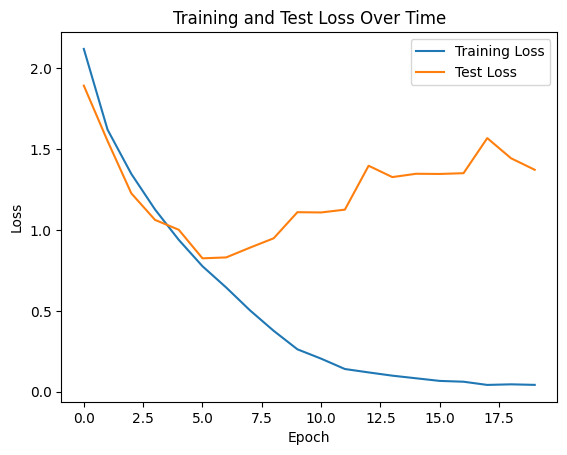

In [12]:
# Plote gráficos de perda
plt.plot(metrics_df['train_loss'], label='Training Loss')
plt.plot(metrics_df['test_loss'], label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Time')
plt.show()


In [13]:
# plot_confusion_matrix(alexnet, trainloader, CIFAR10_CLASSES,device,'train')

In [14]:
# plot_confusion_matrix(alexnet, testloader, CIFAR10_CLASSES, device,'test')

Evaluating Model: 100%|██████████| 391/391 [00:32<00:00, 12.19it/s]


Classification Report:
              precision    recall  f1-score   support

    airplane       0.99      0.98      0.99      2491
  automobile       1.00      0.98      0.99      2518
        bird       0.98      0.98      0.98      2515
         cat       0.97      1.00      0.98      2522
        deer       0.99      0.99      0.99      2490
         dog       1.00      0.97      0.98      2411
        frog       1.00      1.00      1.00      2537
       horse       1.00      0.99      1.00      2530
        ship       0.98      1.00      0.99      2507
       truck       0.98      0.99      0.99      2479

    accuracy                           0.99     25000
   macro avg       0.99      0.99      0.99     25000
weighted avg       0.99      0.99      0.99     25000



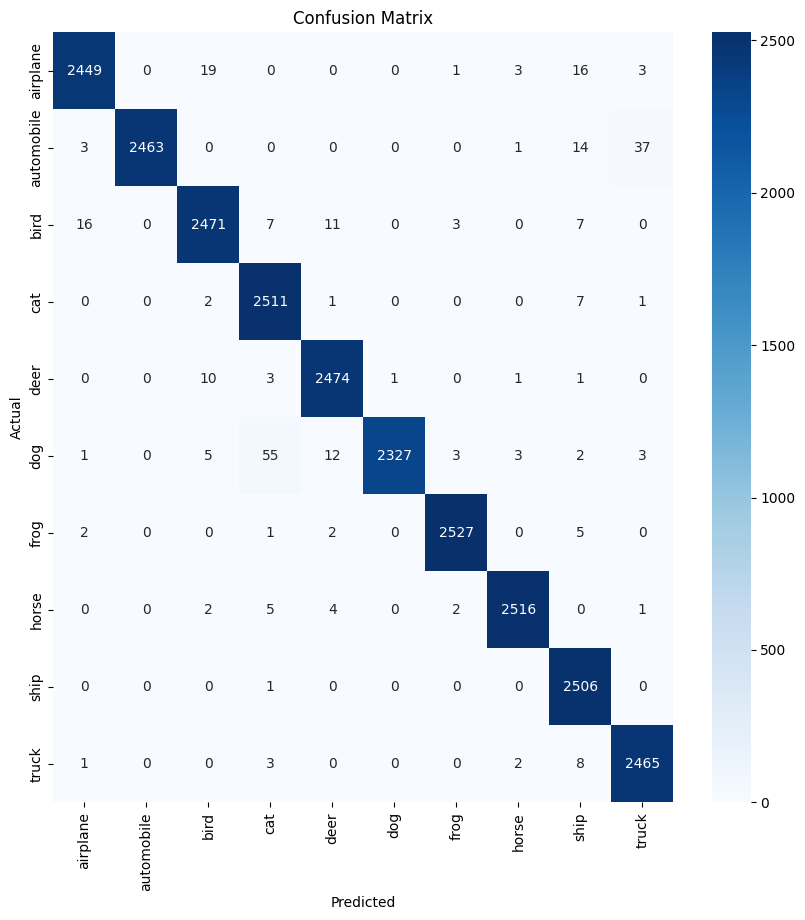

In [16]:
# Evaluate the model on the training set
evaluate_model(alexnet, trainloader, CIFAR10_CLASSES,device)

Evaluating Model: 100%|██████████| 79/79 [00:06<00:00, 12.22it/s]


Classification Report:
              precision    recall  f1-score   support

    airplane       0.78      0.77      0.77       488
  automobile       0.92      0.82      0.87       505
        bird       0.69      0.61      0.65       512
         cat       0.53      0.63      0.58       497
        deer       0.75      0.72      0.73       507
         dog       0.76      0.55      0.64       488
        frog       0.77      0.81      0.79       491
       horse       0.80      0.83      0.81       495
        ship       0.72      0.91      0.80       504
       truck       0.83      0.84      0.83       513

    accuracy                           0.75      5000
   macro avg       0.76      0.75      0.75      5000
weighted avg       0.76      0.75      0.75      5000



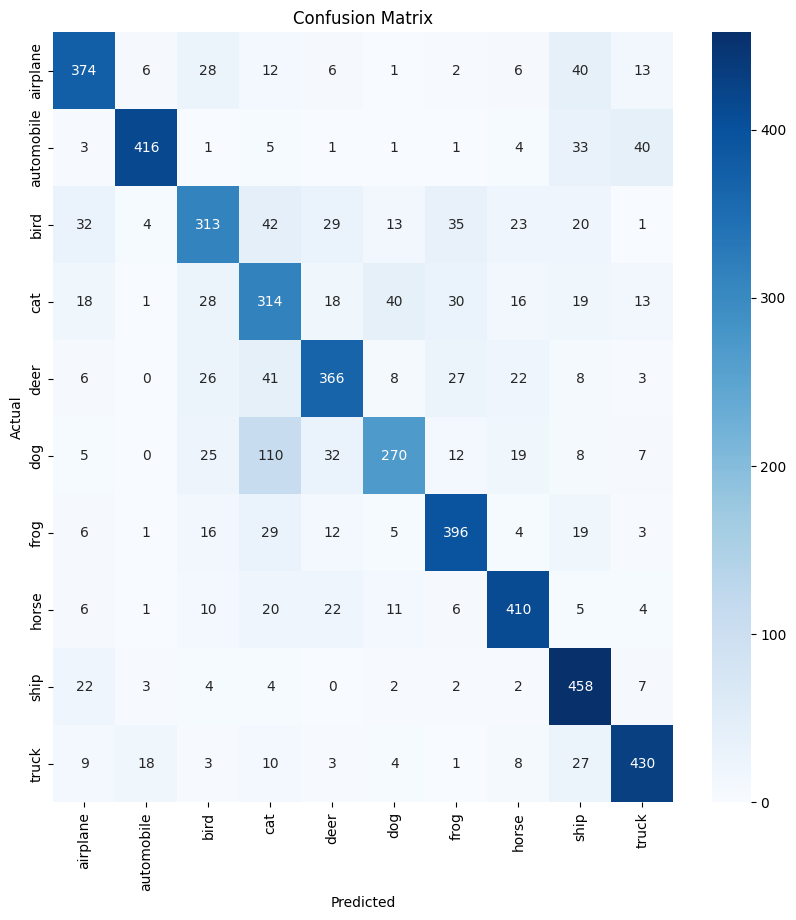

In [17]:
# Evaluate the model on the test set
evaluate_model(alexnet, testloader, CIFAR10_CLASSES,device)